Plotting Last Image
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg


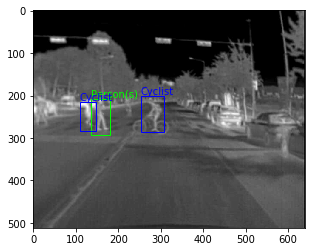

In [3]:
#pip
!pip install torchvision

In [59]:
#imports
import pandas as pd
import os
import numpy as np
from numpy.distutils.misc_util import is_sequence
from bs4 import BeautifulSoup #this is to extract info from the xml, if we use it in the end
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score


Plotting Last Image
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg


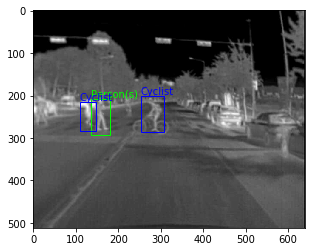

In [5]:

batch_size = 10
num_epochs = 1


Plotting Last Image
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg


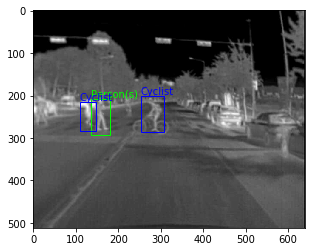

In [6]:
# Get label and encode
def get_box(obj):
    xmin = float(obj.find('xmin').text)
    xmax = float(obj.find('xmax').text)
    ymin = float(obj.find('ymin').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == 'person' or obj.find('name').text == 'people':
        return 1
    if obj.find('name').text == 'cyclist':
        return 2
    else:
        return 0

# Generate the target location in the image
def generate_target(image_id,file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml') #probably will have to change this
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))

        # Converting to a tensor
        # print(boxes)
        # print(labels)
        # print(image_id)
        # print(file)
        # print(is_sequence(boxes))
        # print(is_sequence(labels))
        # print(torch.as_tensor(labels, dtype=torch.int64))
        # print(torch.as_tensor(boxes, dtype=torch.int64))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        # Creating the target for the box
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id

        return target

def OHE(label):
  if label == "People" or label== "Person":
      return 1
  elif label == "Cyclist":
      return 2
  else:
      return 0

def Recode(label):
  if label == 1:
      return "Person(s)"
  elif label == 2:
      return "Cyclist"
  else:
      return "N/A"

class FullImages(object):
    def __init__(self, transforms=None):
        self.csv = pd.read_csv("frame_MasterList.csv")  # will always grab this
        self.csv_len = self.csv.shape[1]
        self.imgs = self.csv.image_path.tolist()
        self.imgs_len = len(self.imgs)
        self.transforms = transforms

    def __len__(self):
       return int(self.imgs_len/150)
       #return self.csv_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.csv.loc[idx, 'image_path']
        annotation = self.csv.loc[idx, 'annotation_path']

        img = Image.open(img).convert("L")
        target = generate_target(idx, annotation)

        # label = self.labels[idx]
        # label = OHE(label)
        # label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


Plotting Last Image
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg


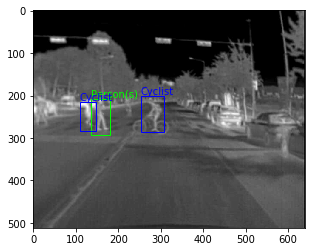

In [7]:
# Normalize
data_transform = transforms.Compose([#transforms.Resize((80,50)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5]
                                                          )])

# Collate images
def collate_fn(batch):
    return tuple(zip(*batch)) #will need adjusting when pathing is adjusted

dataset = FullImages(data_transform)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size, #may want to adjust this
    collate_fn = collate_fn
)

# Check if GPU
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Instance segmentation is crucial in using the full images
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes)
    return model


Plotting Last Image
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg
/Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/Sets/set01/V003/lwir/I00630.jpg


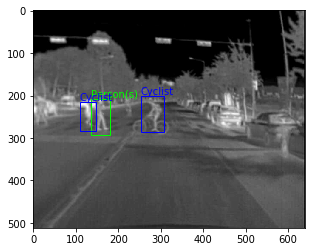

In [8]:
len_dataloader = len(data_loader)
#print("i: " +str(len_dataloader))

cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
model = get_model_instance_segmentation(3)
model.to(device)
params = [p for p in cnn.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)

tot_ats = 0
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    i = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        #losses, outputs = model(imgs, annotations)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses

        i += 1
        tot_ats += 1

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
    print(epoch_loss/i)

print(f'Annotations Trained: {tot_ats}')

In [ ]:
print("Model Evaluation")
model.eval()

master_csv = pd.read_csv("frame_MasterList.csv")
preds = model(imgs)
pred_len = len(preds)
print(f'Length of Predictions: {pred_len}')


In [44]:
def plot_images(num, input):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    img_tensor = imgs[num]
    annotation = annotations[num]
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        #print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[0].text(target_x, target_y, text, color=colors[value])
        ax[0].add_patch(rect)
        ix += 1
        

    ix = 0
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes")
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = prediction["labels"][ix]
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[1].text(target_x, target_y, text, color=colors[value])
        ax[1].add_patch(rect)
        ix += 1
        
    #figname = file_name+"_"+input+".png"
    #fig.savefig(figname)
    plt.show()



100 prediction boxes made for 3 actual boxes


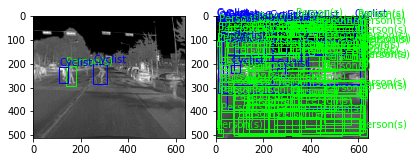

In [58]:
plot_images(0, "first")


100 prediction boxes made for 3 actual boxes


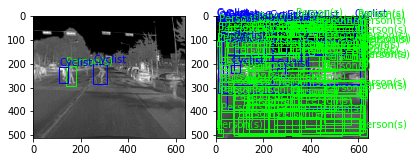

In [56]:

plot_images(pred_len-3, "third_to_last")

100 prediction boxes made for 3 actual boxes


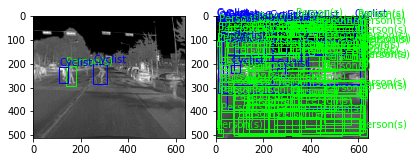

In [57]:

plot_images(pred_len-2, "second_to_last")

100 prediction boxes made for 3 actual boxes


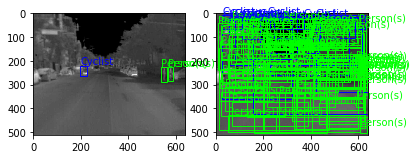

In [55]:
plot_images(pred_len-1, "last")